## Building the dataset

Based on [this paper][https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf], we build an MLP that trains the embeddings of the characters to learn some semantic meaning behind the letters and how they interact together. 

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
block_size = 3
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '->', itos[ix])
        context = context[1:] + [ix] # sliding window: take the last 2 and add the new one to the end

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... -> e
..e -> m
.em -> m
emm -> a
mma -> .
olivia
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .
ava
... -> a
..a -> v
.av -> a
ava -> .
isabella
... -> i
..i -> s
.is -> a
isa -> b
sab -> e
abe -> l
bel -> l
ell -> a
lla -> .
sophia
... -> s
..s -> o
.so -> p
sop -> h
oph -> i
phi -> a
hia -> .


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## Embeddings layer

![image](images/MLP_arch.png)

In the paper, they reduce 17,000 words into 30D vectors. We can reduce our 27 characters to a 2D space. `C` is the lookup table.

In [8]:
C = torch.randn((27, 2), requires_grad=True)
C.shape

torch.Size([27, 2])

In [9]:
C[5]

tensor([0.0075, 0.7233], grad_fn=<SelectBackward0>)

In [10]:
C[[0, 1, 6, 26]]

tensor([[ 1.3206, -1.4657],
        [-0.3051, -0.8130],
        [ 0.2171,  0.1346],
        [-1.2385,  0.3596]], grad_fn=<IndexBackward0>)

In [11]:
X

# ['.', '.', '.']
# ['.', '.', 'e']
# .
# .
# .

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [12]:
X.shape

torch.Size([32, 3])

In [13]:
C[X].shape

# ['.', '.', '.'] -> [2D embedding, 2D embedding, 2D embedding]
# For each of the 32 instances in X

torch.Size([32, 3, 2])

In [14]:
X[3, 2]

# 3rd instance: ['e', 2nd char: 'm', 'm'] -> 'm' -> 13

tensor(13)

In [15]:
print(C[X][3, 2])
print(C[13])

tensor([2.2729, 0.6260], grad_fn=<SelectBackward0>)
tensor([2.2729, 0.6260], grad_fn=<SelectBackward0>)


In [16]:
emb_X = C[X]
emb_X.shape

torch.Size([32, 3, 2])

## Hidden layer (first linear layer in MLP)

Our model has a block size of 3, so 3 2D vectors are the input to this layer -> 6D i/p

In [17]:
W1 = torch.randn((6, 100), requires_grad=True) # 100 neurons in the hidden layer
b1 = torch.randn((100), requires_grad=True)

In [18]:
emb_X.shape, W1.shape, b1.shape

(torch.Size([32, 3, 2]), torch.Size([6, 100]), torch.Size([100]))

In [19]:
emb_X @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [20]:
# Embeddings of the first char (3 block size) of each instance
emb_X[:, 0, :].shape

torch.Size([32, 2])

In [21]:
torch.cat([emb_X[:, 0, :], emb_X[:, 1, :], emb_X[:, 2, :]], dim=1).shape

# dim = 0 will add to rows and then the shape will be (94, 2)


torch.Size([32, 6])

We can use unbind to this dynamically and work for any block size

In [22]:
ex = torch.randn((32, 3, 2))
len(torch.unbind(ex, dim=0))

# 32 of (3, 2): [[[1, 1], [1, 2], [27, 32]], \
# [[1, 1], [1, 2], [27, 32]], \
# [[1, 1], [1, 2], [27, 32]]] -> 32 of (1): [[1, 1], [1, 2], [27, 32], [1, 1], [1, 2], [27, 32], [1, 1], [1, 2], [27, 32]]

# Unpacked about the 0th dimension

32

In [23]:
len(torch.unbind(ex, dim=1))

3

In [24]:
ex[0]

tensor([[-0.1476,  0.1504],
        [-1.1629, -0.7055],
        [-0.9648,  1.5163]])

In [25]:
ex[1]

tensor([[ 0.8017, -1.4586],
        [-0.0048,  0.5327],
        [-0.6082,  0.2489]])

In [26]:
torch.unbind(ex, dim=1)[0] # First chars (total 3) of each instance -> 32, each 2D

tensor([[-0.1476,  0.1504],
        [ 0.8017, -1.4586],
        [ 0.8218, -0.6907],
        [ 0.1365, -2.1934],
        [-0.2090, -1.6421],
        [-0.5464,  1.5343],
        [ 1.7962, -1.5135],
        [-1.9721,  0.6237],
        [ 0.7505,  0.6151],
        [ 0.0840, -1.2068],
        [ 0.4722,  1.0897],
        [ 0.6305, -1.9281],
        [-1.2358, -1.7581],
        [-1.3158, -1.2507],
        [ 0.1315, -2.6479],
        [-0.4245,  1.3383],
        [ 0.7331,  1.0817],
        [ 1.5797, -0.0921],
        [-0.4659, -1.2351],
        [ 0.9527,  1.0963],
        [-0.3298, -0.9450],
        [ 1.0077,  1.3858],
        [ 0.4483,  0.5616],
        [-0.3011, -0.4569],
        [ 0.9581, -0.1048],
        [ 1.4586,  1.2963],
        [-0.1126,  1.0209],
        [ 1.5950, -0.7169],
        [ 0.2759,  0.9733],
        [ 0.4991,  1.4750],
        [-1.0154, -0.5088],
        [-0.6750, -0.9350]])

In [27]:
torch.unbind(ex, dim=1)[0].shape

torch.Size([32, 2])

In [28]:
torch.cat(torch.unbind(ex, dim=1), dim=1).shape

# same as torch.cat([emb_X[:, 0, :], emb_X[:, 1, :], emb_X[:, 2, :]], dim=1).shape but for any block size

torch.Size([32, 6])

We can use `torch.view` for more simplicity and efficiency

In [29]:
ex2 = torch.randn(18)
ex2.storage()

 0.2929847240447998
 -0.5440716743469238
 0.8568235635757446
 -1.3698652982711792
 0.2465384155511856
 -0.036572135984897614
 -0.7205756306648254
 -0.5481381416320801
 1.3263260126113892
 0.6069775223731995
 -0.6116418838500977
 -0.568511426448822
 -0.9016567468643188
 0.16253167390823364
 -1.5811671018600464
 -0.7312595248222351
 1.1115617752075195
 0.9500755071640015
[torch.FloatStorage of size 18]

Tensors are always stored as a group of numbers in memory. We can use `torch.view()` to pack them as we desire.

In [30]:
ex2.view(3, 6)

tensor([[ 0.2930, -0.5441,  0.8568, -1.3699,  0.2465, -0.0366],
        [-0.7206, -0.5481,  1.3263,  0.6070, -0.6116, -0.5685],
        [-0.9017,  0.1625, -1.5812, -0.7313,  1.1116,  0.9501]])

In [31]:
emb_X.view(32, 6) == torch.cat(torch.unbind(emb_X, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

Finally,

In [32]:
h = torch.tanh(emb_X.view(emb_X.shape[0], 6) @ W1 + b1)
h.shape # activations of 100 neurons for each of the 32 instances

torch.Size([32, 100])

Even more dynamic,

In [33]:
h = torch.tanh(emb_X.view(-1, 6) @ W1 + b1) # PyTorch will infer the required size based on that dim 1 = 6
h.shape

torch.Size([32, 100])

## Output

We can build layer 2 now. This is the output layer so we need 27 neurons here (each taking the 100D o/p of previous layer as i/p) to get a prob dist for the next char given a context window of block size 3.

In [34]:
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn((27), requires_grad=True)

In [35]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [36]:
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

In [37]:
probs[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [38]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [39]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [40]:
probs[torch.arange(32), Y] # for 0th instance (32 total), what is the probability of the correct char and so on?

tensor([4.3195e-07, 9.6817e-10, 1.9185e-17, 4.7525e-07, 1.4974e-11, 4.3812e-10,
        3.8567e-06, 1.4147e-07, 4.6214e-04, 2.0870e-07, 1.0588e-13, 1.4611e-08,
        4.3782e-04, 2.2789e-02, 8.4873e-07, 5.3695e-08, 1.1222e-07, 1.5205e-02,
        1.4268e-08, 3.5526e-12, 9.5413e-13, 1.2677e-10, 2.1710e-06, 7.9949e-13,
        4.3678e-07, 2.4414e-06, 3.3391e-07, 8.6798e-08, 5.6074e-09, 6.7978e-09,
        2.6961e-09, 3.7320e-09], grad_fn=<IndexBackward0>)

In [41]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(17.7515, grad_fn=<NegBackward0>)

In [42]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [43]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), requires_grad=True, generator=g)
W1 = torch.randn((6, 100), requires_grad=True, generator=g)
b1 = torch.randn((100), requires_grad=True, generator=g)
W2 = torch.randn((100, 27), requires_grad=True, generator=g)
b2 = torch.randn((27), requires_grad=True, generator=g)
parameters = [C, W1, b1, W2, b2]

In [44]:
sum(p.nelement() for p in parameters)

3481

In [45]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(32), Y].log().mean()
loss



tensor(17.7697, grad_fn=<NegBackward0>)

In [46]:
loss = F.cross_entropy(logits, Y) 
loss

tensor(17.7697, grad_fn=<NllLossBackward0>)

## Training

In [47]:
for p in parameters:
    p.requires_grad = True

In [48]:
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y) 
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

17.76971435546875
13.656403541564941
11.298772811889648
9.452458381652832
7.984263896942139
6.891322135925293
6.100015640258789
5.452036380767822
4.8981523513793945
4.4146647453308105


Let us create the entire training set

In [66]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [67]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [68]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), requires_grad=True, generator=g)
W1 = torch.randn((6, 100), requires_grad=True, generator=g)
b1 = torch.randn((100), requires_grad=True, generator=g)
W2 = torch.randn((100, 27), requires_grad=True, generator=g)
b2 = torch.randn((27), requires_grad=True, generator=g)
parameters = [C, W1, b1, W2, b2]

In [69]:
sum(p.nelement() for p in parameters)

3481

In [70]:
for p in parameters:
    p.requires_grad = True

In [71]:
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y) 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

print(loss.item())

11.05185604095459


We can implement mini-batch gradient descent to speed up training.

In [59]:
torch.randint(0, X.shape[0], (32,)) # randomly sampled mini-batch of 32 instances

In [ ]:
for _ in range(1000):
    # mini-batch construction
    ix = torch.randint(0, X.shape[0], (32,), generator=g)
    Xb = X[ix]
    Yb = Y[ix]

    # forward pass
    emb = C[Xb]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

print(loss.item())

4.594913005828857


Let us find the optimal learning rate through experimentation. We can create exponentially spaced lrs within the interval 0.001 (10^-3) and 0 (10^0)

In [81]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [82]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), requires_grad=True, generator=g)
W1 = torch.randn((6, 100), requires_grad=True, generator=g)
b1 = torch.randn((100), requires_grad=True, generator=g)
W2 = torch.randn((100, 27), requires_grad=True, generator=g)
b2 = torch.randn((27), requires_grad=True, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)

for p in parameters:
    p.requires_grad = True

    

lri, lossi = [], []

for i in range(1000):
    # mini-batch construction
    ix = torch.randint(0, X.shape[0], (32,), generator=g)
    Xb = X[ix]
    Yb = Y[ix]

    # forward pass
    emb = C[Xb]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= lrs[i] * p.grad

    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

8.429215431213379


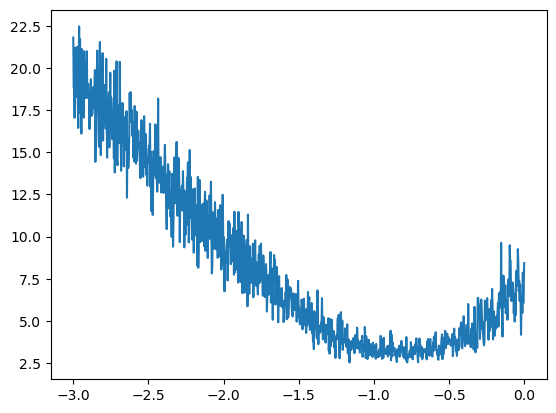

In [83]:
plt.plot(lri, lossi)

We appended lre (not lrs itself) to lri. We can see that the loss is lowest around [-1, -0.5]. Therefore, our chosen rate of -1 or 10^-1 or 0.1 was good.

In [84]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), requires_grad=True, generator=g)
W1 = torch.randn((6, 100), requires_grad=True, generator=g)
b1 = torch.randn((100), requires_grad=True, generator=g)
W2 = torch.randn((100, 27), requires_grad=True, generator=g)
b2 = torch.randn((27), requires_grad=True, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)

for p in parameters:
    p.requires_grad = True

We can also implement some lr decay. We can ran the below followed by the forward pass multiple times till the loss plateaus, then we reduce the lr (to say 0.001) and keep checking if the loss is decreasing

In [104]:
for i in range(10000):
    # mini-batch construction
    ix = torch.randint(0, X.shape[0], (32,), generator=g)
    Xb = X[ix]
    Yb = Y[ix]

    # forward pass
    emb = C[Xb]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.01 * p.grad

Let us do a forward pass on the training set to get the loss

In [105]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

2.34626841545105